In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
with open('data/gs_single.pkl', 'rb') as f:
    gs_single = pickle.load(f)

with open('data/gs_binary.pkl', 'rb') as f:
    gs_binary = pickle.load(f)

In [3]:
def build_grid(data, metric, normalized_val):
    """Average metric over folds for a given normalized setting, return 2-D grid (s x p)."""
    s_arr  = np.asarray(data['params']['s'])
    p_arr  = np.asarray(data['params']['p'])
    nm_arr = np.asarray(data['params']['normalized'])
    acc    = np.asarray(data['results'][metric], dtype=float)

    mask = nm_arr == normalized_val
    s_m, p_m, acc_m = s_arr[mask], p_arr[mask], acc[mask]

    su = np.unique(s_m)
    pu = np.unique(p_m)

    # group by (s, p) and mean over folds
    idx = np.lexsort((p_m, s_m))
    s_s, p_s, acc_s = s_m[idx], p_m[idx], acc_m[idx]
    chg = (s_s[1:] != s_s[:-1]) | (p_s[1:] != p_s[:-1])
    starts = np.r_[0, np.flatnonzero(chg) + 1]
    means  = np.add.reduceat(acc_s, starts) / np.diff(np.r_[starts, acc_s.size])

    grid = np.full((su.size, pu.size), np.nan)
    si = np.searchsorted(su, s_s[starts])
    pi = np.searchsorted(pu, p_s[starts])
    grid[si, pi] = means
    return grid, su, pu


def plot_heatmaps(data, title_prefix):
    """Plot 2x2 heatmaps: rows = train/test accuracy, cols = normalized False/True."""
    metrics    = ['train_acc', 'test_acc']
    norm_vals  = [False, True]
    row_labels = ['Train accuracy', 'Test accuracy']
    col_labels = ['Not normalised', 'Normalised']

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(title_prefix, fontsize=14, fontweight='bold')

    # find global vmin/vmax across all panels for consistent colour scale
    all_grids = [build_grid(data, m, nv)[0] for m in metrics for nv in norm_vals]
    vmin = np.nanmin([g.min() for g in all_grids])
    vmax = np.nanmax([g.max() for g in all_grids])

    for row, (metric, row_label) in enumerate(zip(metrics, row_labels)):
        for col, (nv, col_label) in enumerate(zip(norm_vals, col_labels)):
            ax = axes[row, col]
            grid, su, pu = build_grid(data, metric, nv)

            im = ax.imshow(
                grid, aspect='auto', origin='lower',
                vmin=vmin, vmax=vmax, cmap='viridis'
            )

            ax.set_xticks(np.arange(pu.size))
            ax.set_xticklabels([f'{v:.3f}' for v in pu], rotation=45, ha='right', fontsize=7)
            ax.set_yticks(np.arange(su.size))
            ax.set_yticklabels([f'{v:.3f}' for v in su], fontsize=7)
            ax.set_xlabel('p (Bernoulli sampling)', fontsize=9)
            ax.set_ylabel('s (sparsity)', fontsize=9)
            ax.set_title(f'{row_label} — {col_label}', fontsize=10)

            # annotate cells
            thresh = (vmin + vmax) / 2
            for i in range(grid.shape[0]):
                for j in range(grid.shape[1]):
                    if np.isfinite(grid[i, j]):
                        color = 'white' if grid[i, j] < thresh else 'black'
                        ax.text(j, i, f'{grid[i, j]:.2f}',
                                ha='center', va='center', fontsize=5.5, color=color)

            fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

## Single-odour gridsearch (`gs_single`)

Parameters swept:
- **s** – fraction of HD neurons that are active (top-k sparsity)
- **p** – Bernoulli sampling probability applied during online weight update
- **normalized** – whether sensor data is min-max normalised before encoding

Each cell shows the mean accuracy averaged over 10 cross-validation folds.

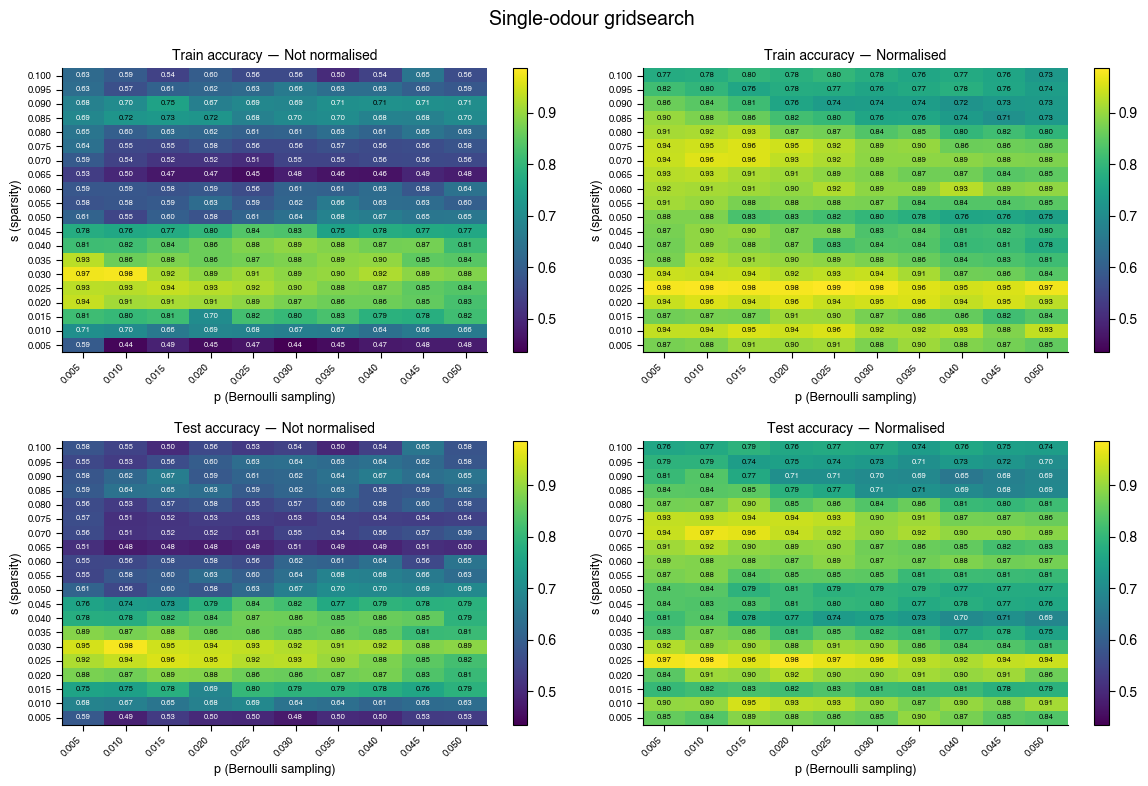

In [4]:
plot_heatmaps(gs_single, 'Single-odour gridsearch')

In [5]:
# Best params summary for gs_single
for metric, label in [('test_acc', 'Test'), ('train_acc', 'Train')]:
    acc    = np.asarray(gs_single['results'][metric], dtype=float)
    s_arr  = np.asarray(gs_single['params']['s'])
    p_arr  = np.asarray(gs_single['params']['p'])
    nm_arr = np.asarray(gs_single['params']['normalized'])
    nf_arr = np.asarray(gs_single['params']['n_fold'])

    for nv in [False, True]:
        mask = nm_arr == nv
        s_m, p_m, acc_m, nf_m = s_arr[mask], p_arr[mask], acc[mask], nf_arr[mask]

        idx = np.lexsort((p_m, s_m))
        s_s, p_s, acc_s = s_m[idx], p_m[idx], acc_m[idx]
        chg = (s_s[1:] != s_s[:-1]) | (p_s[1:] != p_s[:-1])
        starts = np.r_[0, np.flatnonzero(chg) + 1]
        means  = np.add.reduceat(acc_s, starts) / np.diff(np.r_[starts, acc_s.size])

        best = int(np.nanargmax(means))
        best_s = s_s[starts[best]]
        best_p = p_s[starts[best]]

        bp_mask = (s_m == best_s) & (p_m == best_p)
        best_vals = acc_m[bp_mask]

        print(
            f'[{label} | normalised={nv}] Best: s={best_s:.3f}, p={best_p:.3f}  '
            f'mean={np.mean(best_vals):.4f} ± {np.std(best_vals):.4f}  '
            f'max={np.max(best_vals):.4f}'
        )

[Test | normalised=False] Best: s=0.030, p=0.010  mean=0.9773 ± 0.0158  max=1.0000
[Test | normalised=True] Best: s=0.025, p=0.010  mean=0.9813 ± 0.0126  max=1.0000
[Train | normalised=False] Best: s=0.030, p=0.010  mean=0.9773 ± 0.0121  max=0.9889
[Train | normalised=True] Best: s=0.025, p=0.025  mean=0.9856 ± 0.0056  max=0.9933


## Binary-mixture gridsearch (`gs_binary`)

Same parameter grid as the single-odour case, but trained on binary mixture data.

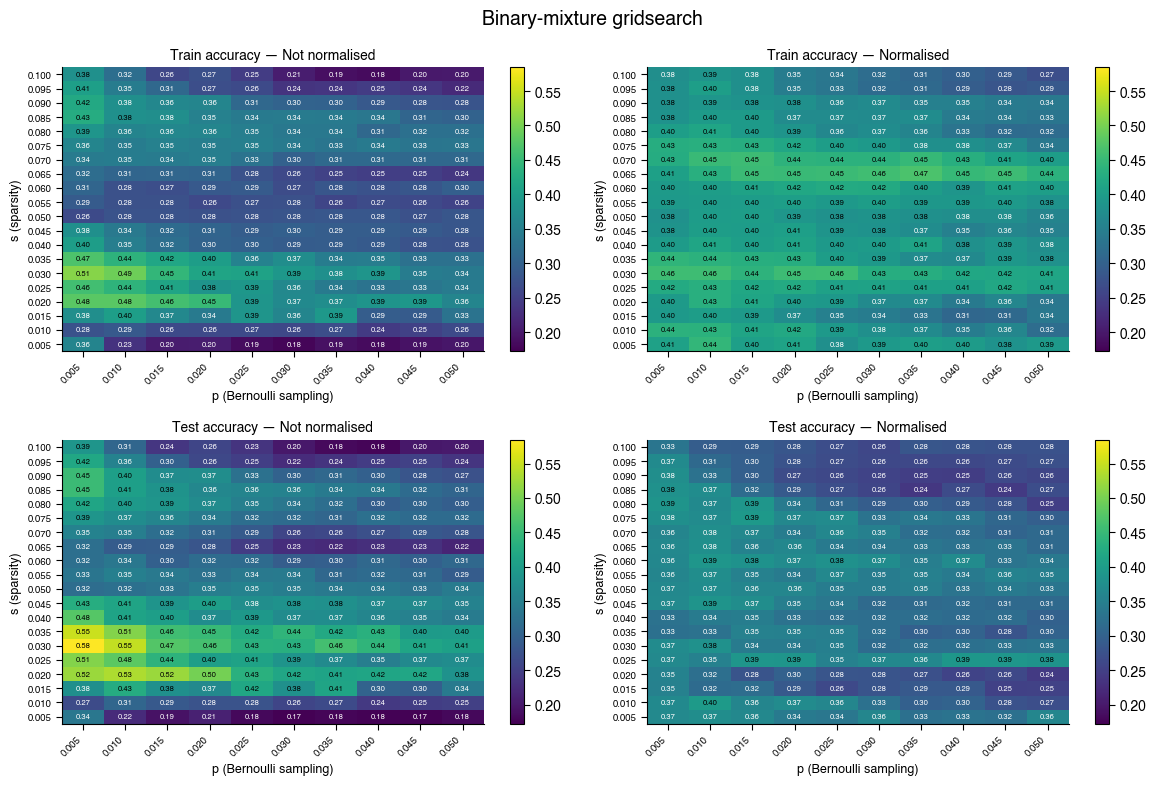

In [6]:
plot_heatmaps(gs_binary, 'Binary-mixture gridsearch')

In [7]:
# Best params summary for gs_binary
for metric, label in [('test_acc', 'Test'), ('train_acc', 'Train')]:
    acc    = np.asarray(gs_binary['results'][metric], dtype=float)
    s_arr  = np.asarray(gs_binary['params']['s'])
    p_arr  = np.asarray(gs_binary['params']['p'])
    nm_arr = np.asarray(gs_binary['params']['normalized'])
    nf_arr = np.asarray(gs_binary['params']['n_fold'])

    for nv in [False, True]:
        mask = nm_arr == nv
        s_m, p_m, acc_m, nf_m = s_arr[mask], p_arr[mask], acc[mask], nf_arr[mask]

        idx = np.lexsort((p_m, s_m))
        s_s, p_s, acc_s = s_m[idx], p_m[idx], acc_m[idx]
        chg = (s_s[1:] != s_s[:-1]) | (p_s[1:] != p_s[:-1])
        starts = np.r_[0, np.flatnonzero(chg) + 1]
        means  = np.add.reduceat(acc_s, starts) / np.diff(np.r_[starts, acc_s.size])

        best = int(np.nanargmax(means))
        best_s = s_s[starts[best]]
        best_p = p_s[starts[best]]

        bp_mask = (s_m == best_s) & (p_m == best_p)
        best_vals = acc_m[bp_mask]

        print(
            f'[{label} | normalised={nv}] Best: s={best_s:.3f}, p={best_p:.3f}  '
            f'mean={np.mean(best_vals):.4f} ± {np.std(best_vals):.4f}  '
            f'max={np.max(best_vals):.4f}'
        )

[Test | normalised=False] Best: s=0.030, p=0.005  mean=0.5843 ± 0.0507  max=0.6600
[Test | normalised=True] Best: s=0.010, p=0.010  mean=0.3970 ± 0.0603  max=0.4900
[Train | normalised=False] Best: s=0.030, p=0.005  mean=0.5092 ± 0.0421  max=0.5583
[Train | normalised=True] Best: s=0.065, p=0.035  mean=0.4672 ± 0.0183  max=0.4967
